In [1]:
import deepdoctection as dd
from pathlib import Path
import pandas as pd
import json
from matplotlib import pyplot as plt
pd.set_option('display.max_colwidth', None)
import jsonlines

In [5]:
# Eingabe des Quellverzeichnisses 

BASE_PATH = Path("/home/janis/Data/raw_cited_items")

### Ermittlung fehlender Dokumente

In [6]:
pedocs_jsonl = BASE_PATH / "pedocs.jsonl"

# Alle verschiedenen doc_ids, die im pedocs file enthalten sind
df = dd.SerializerJsonlines.load(pedocs_jsonl)
df.reset_state()
all_items = []
for dp in df:
    all_items.append(dp)
    
df_frame = pd.DataFrame.from_records(all_items)
all_doc_ids = set(df_frame['doc_id'].tolist())

In [7]:
len(all_doc_ids)

1795

Es fehlen 11 Dokumente, denn wir haben 1806 pdfs in full_cut_files.

#### Die folgenden beiden Zellen nicht ausführen !

In [4]:
df = dd.SerializerFiles.load("/home/janis/Data/full_cut_files",file_type=".pdf")
all_files = []
df.reset_state()

for dp in df:
    all_files.append(Path(dp).stem)
all_files = set(all_files)

|                                                                                                                                                                                             |1806/?[00:00<00:00,66140.85it/s]


In [5]:
all_files - all_doc_ids

{'0248d785d7f43ac8030656a195a0163e9d7fdb3d',
 '0bf769b2c37486fd52b2aafe4156099398edcbb6',
 '17917cee0d9d890dc5c410f99a4eb856a76a3818',
 '1b0ee598e371ebf92f6731a8b00a05ed41f398e0',
 '23fb1e218b3c6de932fe88b0598469b29adef54f',
 '2f0e8092d63998a34bd562fce53a3dbb984cbc8f',
 '3ef1c105466a382ed88eb71771421aa50f962b71',
 '76023850d72eae350f382c91b575768b7e63c43e',
 '7992c4bdb59fe37a56b24568d9f966d27200658e',
 'a4d7437df82793eaa32ea932a4d4138cc87c0947',
 'ab78002a738f810aef58251172e0f408a66b30e8'}

In [8]:
# Nachweis, dass wir keine Einträge im pedocs file haben

doc_id = "0bf769b2c37486fd52b2aafe4156099398edcbb6"
all_elements = df_frame[df_frame['doc_id']==doc_id]
all_elements

,doc_id,file_name,annotation_id,text,page_num,reading_order


In [9]:
# Wie viele Seiten haben wir für das Dokument verarbeitet
df = dd.SerializerFiles.load(BASE_PATH,file_type=".json")
df.reset_state()
all_json_files = []
for dp in df:
    all_json_files.append(Path(dp).stem)
items_found = []
for element in all_json_files:
    if doc_id in element:
        items_found.append(element)
items_found

|                                                                                                                                                                                             |4973/?[00:00<00:00,95780.33it/s]


['0bf769b2c37486fd52b2aafe4156099398edcbb6_0']

In [11]:
# Aufruf eine Seite per Dokument. ".pdf muss immer angefügt werden

file_name = "0bf769b2c37486fd52b2aafe4156099398edcbb6_0.pdf"
path_file_name = BASE_PATH / file_name.replace(".pdf",".json")

with open(path_file_name, "r") as file:
    out = json.load(file)
    image = dd.Page.from_dict(**out)
    page = dd.Page.from_image(image,dd.LayoutType.line, [dd.LayoutType.text, 
                                                         dd.LayoutType.title, 
                                                         dd.LayoutType.list, 
                                                         dd.LayoutType.table, 
                                                         dd.LayoutType.figure,])

all_elements_one_page = df_frame[df_frame['file_name']==file_name]
all_elements_one_page

,doc_id,file_name,annotation_id,text,page_num,reading_order


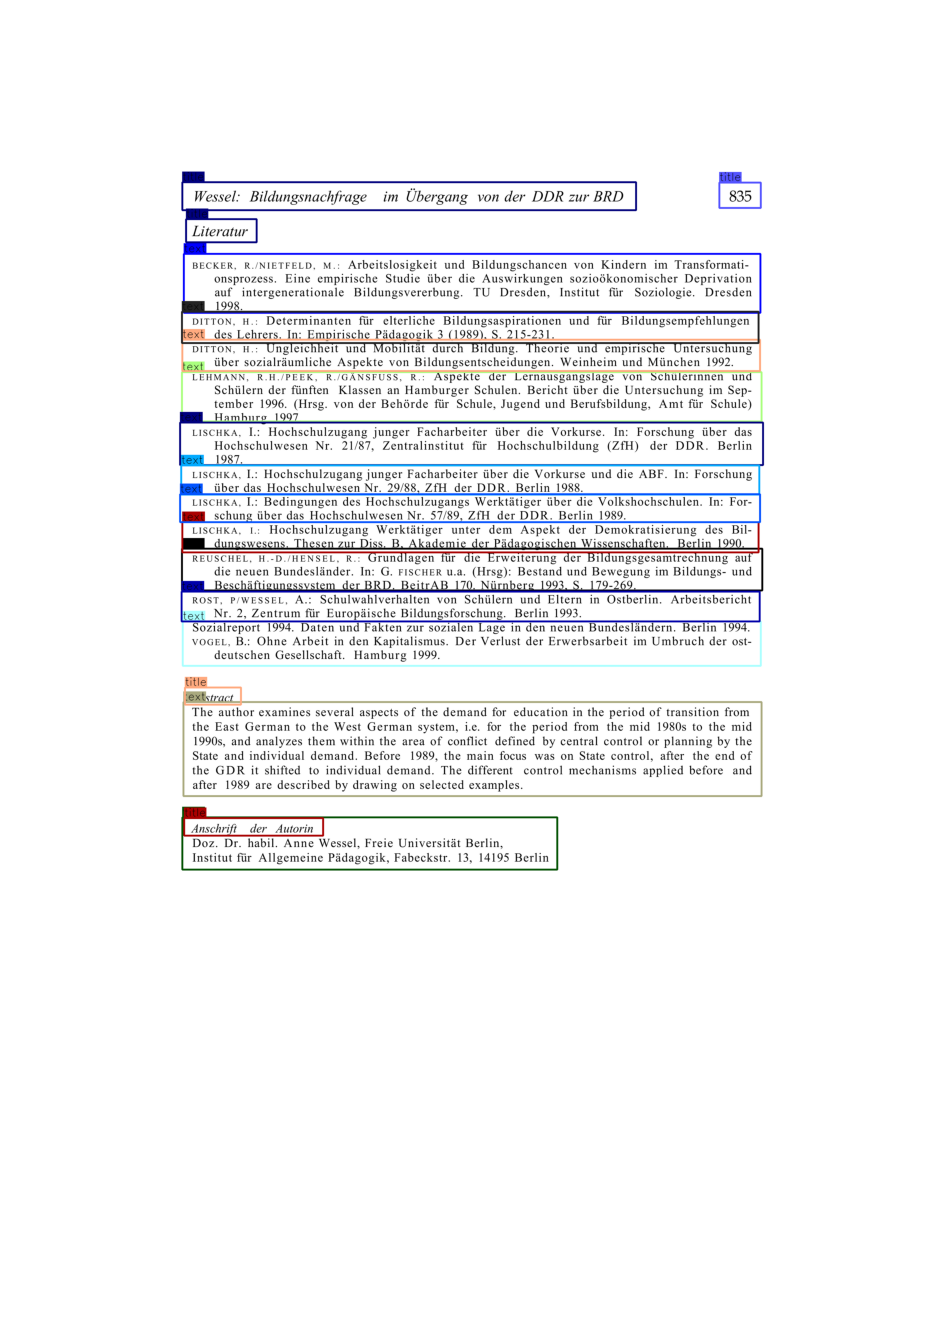

In [12]:
image = page.viz(interactive=False, show_layouts=True)
plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(image)

### Einfügen der fehlenden Blöcke

- Entfernen des # zum Anzeigen der doc_id, file_name
- Jede Box im Bild entspricht einem layout-Block 
- Wir suchen die Boxen mit den cited items. Für xx tragen wir die Zahlen 0 - Anzahl der Blöcke ein 
  `page.layouts[xx].text`
- Wenn wir ein layout Block für relevant erachten, tragen wir den in die Zelle mit `layout_blocks` ein

In [13]:
len(page.layouts)

18

In [19]:

doc_id
#file_name
#page.layouts[2].text

'0bf769b2c37486fd52b2aafe4156099398edcbb6'

In [21]:
layout_blocks = [page.layouts[1],page.layouts[2]]

Wenn wir alle cited items haben, konvertieren wir diese in das Ziel-Scheme der pedocs-Datei. Abschließende Prüfung.

In [22]:
def add_cited_item(document_id, file_name, layout_blocks):
    all_items = []
    for layout in layout_blocks:
        all_items.append({"doc_id": document_id, 
                          "file_name": file_name, 
                          "annotation_id":layout.annotation_id, 
                          "text": layout.text, 
                          "page_num": 0,
                          "reading_order": int(layout.reading_order)})
    return all_items
add_cited_item(doc_id, file_name, layout_blocks)

[{'doc_id': '0bf769b2c37486fd52b2aafe4156099398edcbb6',
  'file_name': '0bf769b2c37486fd52b2aafe4156099398edcbb6_0.pdf',
  'annotation_id': 'ab015a43-558b-3684-82b1-8c8adc112542',
  'text': 'LISCHKA, I.: Hochschulzugang junger Facharbeiter über die Vorkurse. In: Forschung über das Hochschulwesen Nr. 21/87, Zentralinstitut für Hochschulbildung (ZfH) der DDR. Berlin 1987.',
  'page_num': 0,
  'reading_order': 6},
 {'doc_id': '0bf769b2c37486fd52b2aafe4156099398edcbb6',
  'file_name': '0bf769b2c37486fd52b2aafe4156099398edcbb6_0.pdf',
  'annotation_id': '7852558e-614a-3cfa-9ed8-1d3530096e9a',
  'text': 'LEHMANN, R.H./PEEK, R./GÄNSFUSS, R.: Aspekte der Lernausgangslage von Schülerinnen und Schülern der fünften Klassen an Hamburger Schulen. Bericht über die Untersuchung im Sep- tember 1996. (Hrsg. von der Behörde für Schule, Jugend und Berufsbildung, Amt für Schule) Hamburg 1997.',
  'page_num': 0,
  'reading_order': 5}]

### Einfügen der neuen items in die pedocs-Datei

In [23]:
new_items = add_cited_item(doc_id, file_name, layout_blocks)

In [26]:
new_items = add_cited_item(doc_id, file_name, layout_blocks)
with jsonlines.open(str(BASE_PATH / "pedocs.jsonl"), mode='a') as writer:
    for element in new_items:
        writer.write(element)
print("Einfügen erfolgreich")

Einfügen erfolreich
